In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banana/banana_quality.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [3]:
df = pd.read_csv('/kaggle/input/banana/banana_quality.csv')
df.describe()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,-0.747802,-0.761019,-0.770224,-0.014441,-0.751288,0.781098,0.008725
std,2.136023,2.015934,1.948455,2.065216,1.996661,2.114289,2.293467
min,-7.998074,-8.283002,-6.434022,-6.959320,-7.570008,-7.423155,-8.226977
25%,-2.277651,-2.223574,-2.107329,-1.590458,-2.120659,-0.574226,-1.629450
50%,-0.897514,-0.868659,-1.020673,0.202644,-0.934192,0.964952,0.098735
75%,0.654216,0.775491,0.311048,1.547120,0.507326,2.261650,1.682063
max,7.970800,5.679692,7.539374,8.241555,6.293280,7.249034,7.411633


In [4]:
df["Quality"] = df["Quality"].map({"Good": 1, "Bad": 0})
df
num_samples, num_features = df.shape
num_features -= 1
print(num_samples, num_features)

8000 7


In [5]:
X = df.drop(["Quality"], axis=1).values
y = df['Quality'].values.reshape(-1, 1)
X.shape, y.shape

((8000, 7), (8000, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6400, 7), (6400, 1), (1600, 7), (1600, 1))

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((5760, 7), (5760, 1), (640, 7), (640, 1))

In [8]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_valid = x_scaler.transform(X_valid)
X_test = x_scaler.transform(X_test)

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([5760, 7]),
 torch.Size([5760, 1]),
 torch.Size([640, 7]),
 torch.Size([640, 1]),
 torch.Size([1600, 7]),
 torch.Size([1600, 1]))

In [10]:
train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)
test_set = TensorDataset(X_test, y_test)

In [11]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=80)
test_loader = DataLoader(test_set, batch_size=400)

**Model**

In [12]:
model = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
    )
model

Sequential(
  (0): Linear(in_features=7, out_features=1, bias=True)
  (1): Sigmoid()
)

In [13]:
model[0], model[1], model[0].weight, model[0].bias

(Linear(in_features=7, out_features=1, bias=True),
 Sigmoid(),
 Parameter containing:
 tensor([[-0.1386, -0.1324, -0.2685, -0.2373,  0.0046,  0.2187, -0.3152]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2575], requires_grad=True))

In [14]:
loss_fn = nn.BCELoss()
loss_fn

BCELoss()

In [15]:
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [16]:
n_epochs = 10
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []

In [17]:
for epoch in range(n_epochs):

  mean_loss_train, mean_loss_valid = 0, 0
  mean_acc_train, mean_acc_valid = 0, 0

  for x_batch, y_batch in train_loader:

    # model
    y_hat = model(x_batch)

    # loss
    loss = loss_fn(y_hat, y_batch)

    # gradient
    loss.backward()

    # update
    optimizer.step()
    optimizer.zero_grad()

    mean_loss_train += loss.item() * len(x_batch)
    mean_acc_train += torch.sum(y_hat.round() == y_batch).item()

  mean_loss_train = mean_loss_train / len(train_set)
  mean_acc_train = mean_acc_train / len(train_set)

  loss_train_hist.append(mean_loss_train)
  acc_train_hist.append(mean_acc_train)


  with torch.no_grad():
    for x_batch, y_batch in valid_loader:
      y_hat = model(x_batch)
      loss = loss_fn(y_hat, y_batch)
      mean_loss_valid += loss.item() * len(x_batch)
      mean_acc_valid += torch.sum(y_hat.round() == y_batch).item()

    mean_loss_valid = mean_loss_valid / len(valid_set)
    mean_acc_valid = mean_acc_valid / len(valid_set)

    loss_valid_hist.append(mean_loss_valid)
    acc_valid_hist.append(mean_acc_valid)

  print(
  f"Epoch: {epoch}   "
  f"LossTrain: {mean_loss_train:.2}   "
  f"AccTrain: {mean_acc_train:.2}   "
  f"LossValid: {mean_loss_valid:.2}   "
  f"AccValid: {mean_acc_valid:.2}"
  )

Epoch: 0   LossTrain: 0.35   AccTrain: 0.83   LossValid: 0.28   AccValid: 0.88
Epoch: 1   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.88
Epoch: 2   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.88
Epoch: 3   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.29   AccValid: 0.88
Epoch: 4   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.88
Epoch: 5   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.88
Epoch: 6   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.88
Epoch: 7   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.88
Epoch: 8   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.89
Epoch: 9   LossTrain: 0.29   AccTrain: 0.88   LossValid: 0.28   AccValid: 0.88


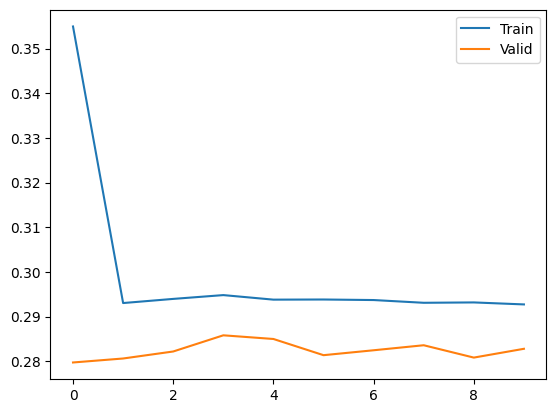

In [18]:
plt.plot(torch.arange(n_epochs), loss_train_hist)
plt.plot(torch.arange(n_epochs), loss_valid_hist)
plt.legend(["Train", "Valid"]);

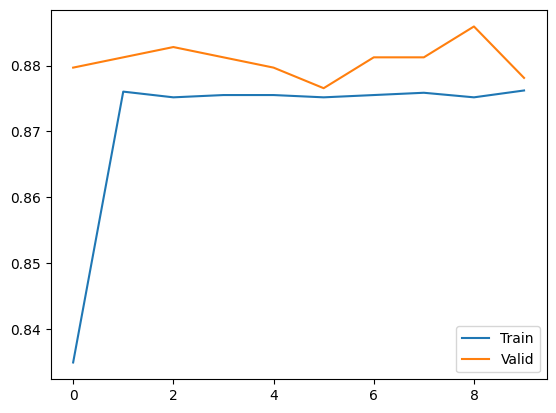

In [19]:
plt.plot(torch.arange(n_epochs), acc_train_hist)
plt.plot(torch.arange(n_epochs), acc_valid_hist)
plt.legend(["Train", "Valid"]);

In [20]:
mean_acc_test = 0

with torch.no_grad():
  for x_batch, y_batch in test_loader:
    y_hat = model(x_batch)
    mean_acc_test += torch.sum(y_hat.round() == y_batch).item()
  mean_acc_test = mean_acc_test / len(test_set)

mean_acc_test

0.883125